## Step 0: Pre-Requirements - Import Modules 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib
from statsmodels.tools.eval_measures import rmse 
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings 
warnings.filterwarnings("ignore")

Using matplotlib backend: agg


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Step 1 : Import data set and draw ACF / PACF plot then choose time lag

Download the data from https://github.com/Marimuthu8421/LSTM-Models/tree/main/data/India and store it in your local file. Run the below code and click 'Choose Files' then browse your data (.csv file).   

In [ ]:
from google.colab import files
uploaded= files.upload()

Import the uploaded data as name 'df' using the function pd.read_csv(). If you are using other data then please change 'UK covid19 train_data.csv' as data file name.

In [ ]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['India -COVID-19 data_train.csv']))
df.head()

In [ ]:
# Month  is already in index of df otherwise change it usingthe following code
# change the Month column as Index

df1=df
df1.Date=pd.to_datetime(df.Date)
df1=df1.set_index("Date")
df1.head()

,Confirmed,Total Confirmed
Date,,
2021-12-01,9875,34606232
2021-12-02,9191,34615423
2021-12-03,9128,34624551
2021-12-04,8912,34633463
2021-12-05,8413,34641876


Plot line graph for Daily cases using the code given below

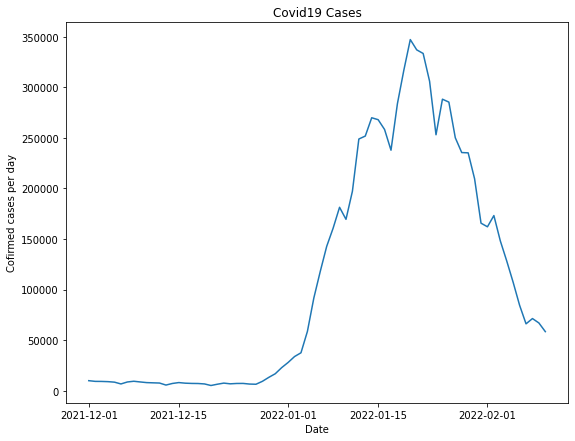

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(df1.index.values, df1['Confirmed'])
ax.set(xlabel="Date",
       ylabel="Cofirmed cases per day",
       title="Covid19 Cases")

plt.show()

Draw ACF / PACF plot using the function accf() / pacf(). Choose the significant lag as the optimal time step which can be used for data pre-processing.

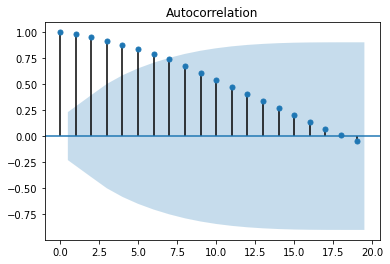

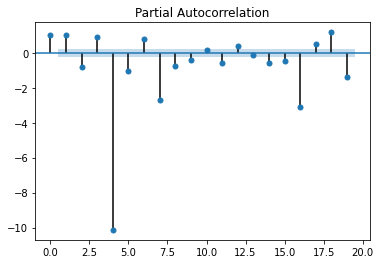

In [ ]:
## Partial Auto correlation Plot
from statsmodels.graphics.tsaplots import acf, pacf, plot_pacf, plot_acf
from matplotlib import pyplot

import numpy as np
dat=np.array(df1['Confirmed'])

plot_acf(dat)
plot_pacf(dat)
pyplot.show()

## step2: Data pre-processing

We can divide the sequence into input (X) and output (y).
Let {Xi, i=1, 2, 3, …, n} be the daily incident cases. Suppose, lag is three, then the fourth day count depends on previous 3 days (third, second and first) and fifth day count depends on fourth, third, and second day counts, and so on. Therefore, the data should be organized as follows:

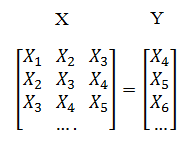

Define the function **prepare_data()** which convert the time series data into X and y.

In [ ]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
n_steps = 6

# split into samples
X, y = prepare_data(df1['Confirmed'], n_steps)
print(X.shape)

In [ ]:
# Summarize the data

for i in range(len(X)):
  print(X[i], y[i])

[9875 9191 9128 8912 8413 6648] 8590
[9191 9128 8912 8413 6648 8590] 9303
[9128 8912 8413 6648 8590 9303] 8614
[8912 8413 6648 8590 9303 8614] 7971
[8413 6648 8590 9303 8614 7971] 7749
[6648 8590 9303 8614 7971 7749] 7545
[8590 9303 8614 7971 7749 7545] 5547
[9303 8614 7971 7749 7545 5547] 7114
[8614 7971 7749 7545 5547 7114] 7996
[7971 7749 7545 5547 7114 7996] 7403
[7749 7545 5547 7114 7996 7403] 7158
[7545 5547 7114 7996 7403 7158] 7079
[5547 7114 7996 7403 7158 7079] 6650
[7114 7996 7403 7158 7079 6650] 5105
[7996 7403 7158 7079 6650 5105] 6378
[7403 7158 7079 6650 5105 6378] 7470
[7158 7079 6650 5105 6378 7470] 6767
[7079 6650 5105 6378 7470 6767] 7116
[6650 5105 6378 7470 6767 7116] 7161
[5105 6378 7470 6767 7116 7161] 6538
[6378 7470 6767 7116 7161 6538] 6342
[7470 6767 7116 7161 6538 6342] 9236
[6767 7116 7161 6538 6342 9236] 13167
[ 7116  7161  6538  6342  9236 13167] 16727
[ 7161  6538  6342  9236 13167 16727] 22775
[ 6538  6342  9236 13167 16727 22775] 27878
[ 6342  9236 131

## Step 3: Reorganize the data as in the format of input to the model

The input data X has the shape [samples, timesteps] and it reshaped before feed into model. The input shape of the Simple LSTM model is [samples, timesteps, features] where feature is always one for univariate time series analysis.

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(66, 6, 1)

## Step 4: Model Buiilding

Sherstinsky et.al (year) discussed the methodology of the Vanilla LSTM model. This is the simple LSTM configuration model compare to other models with one hidden LSTM layer and output layer. We have developed our own model with one LSTM layer followed by eight dense layers. However, the dense layers can be adjusted based on the model perfomance.

In [ ]:
# define model
model = Sequential()
model.add(LSTM(1000, activation='relu', input_shape=(n_steps, n_features)))

model.add(Dense(5000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(3000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(2000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(1000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(500, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(300, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(200, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(100, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(1))

In [ ]:
# Comppile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1000)              4008000   
                                                                 
 dense_30 (Dense)            (None, 5000)              5005000   
                                                                 
 dense_31 (Dense)            (None, 3000)              15003000  
                                                                 
 dense_32 (Dense)            (None, 2000)              6002000   
                                                                 
 dense_33 (Dense)            (None, 1000)              2001000   
                                                                 
 dense_34 (Dense)            (None, 500)               500500    
                                                                 
 dense_35 (Dense)            (None, 300)              

**Call backs**

reuce lr (Learning Rate)-if no  improvement seeing for the patience the learning rate is reuce.

factor - by which the learning eate will be reduce.

patience - # of epochs with no improvement after that the learning rate will reduce

verbose - contain binary 0 quit 1 update message.

mode - auto min max, 
    **min** - LR will reduce when quantity 
monitor has stop decresing;
    **max** -  LR will reduce when quantity monitor has stop incresing;
    **auto** - the direction is automatically infere from the nameof monitor. 

In [ ]:
# Call backs
# reuce lr (Learning Rate)-if no  improvement seeing for the patience the learning rate is reuce
# factor - by which the learning eate will be reduce
# patience - # of epochs with no improvement after that the learning rate will reduce
# verbose - contain binary 0 quit 1 update msg
# mode - auto min max, min - LR will reduce when quantity monitor has stop decresing
#         max -  LR will reduce when quantity monitor has stop incresing
#         auto - the direction is automatically infere from the nameof monitor
# Early stopping  

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

checkpoint=ModelCheckpoint(filepath='best_weights.hdf11', 
                           save_best_only=True, save_weights_only=True)
lr_reduce=ReduceLROnPlateau(monitor='loss',factor=0.3,
                            patience=3,  verbose=2, mode='max')
early_stop=EarlyStopping(monitor='loss',min_delta=0.1, patience=3, mode='min')

## Step 5: Fitting and evaluating the model

Fit a model using the train data and evaluate the performance. The Mean Squared Error (MSE) / Mean Absolute Error (MAE) can be used as the metrics to evaluate model performance of both train and test data. 

In [ ]:
# fit model
model.fit(X, y, epochs=100,batch_size=8, verbose=1,callbacks=[checkpoint,lr_reduce])

Epoch 1/100
9/9 [==============================] - 7s 489ms/step - loss: 75667750912.0000 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 5s 509ms/step - loss: 5525275648.0000 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 4s 492ms/step - loss: 1965441408.0000 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 1857036672.0000WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
9/9 [==============================] - 5s 533ms/step - loss: 1857036672.0000 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 4s 477ms/step - loss: 994441792.0000 - lr: 3.0000e-04
Epoch 6/100
9/9 [==============================] - 4s 454ms/step - loss: 900185024.0000 - lr: 3.0000e-04
Epoch 7/100
9/9 [==============================] - ETA: 0s - loss: 973737472.0000WARNING:tensorflow:Can save best model only with val_loss available, skipp

In [ ]:
## Prediction

y_hat=model.predict(X, verbose=1)
print(y_hat)

3/3 [==============================] - 1s 97ms/step
[[  6831.4487]
 [  8098.2607]
 [  8936.639 ]
 [  8560.402 ]
 [  8191.3145]
 [  7895.057 ]
 [  7149.759 ]
 [  5952.7114]
 [  6636.522 ]
 [  7651.43  ]
 [  7260.913 ]
 [  7249.757 ]
 [  7159.7783]
 [  6732.425 ]
 [  5350.8193]
 [  6062.6787]
 [  7109.525 ]
 [  6633.4844]
 [  7155.3413]
 [  7202.119 ]
 [  6656.264 ]
 [  6064.884 ]
 [  8645.226 ]
 [ 12779.215 ]
 [ 16285.553 ]
 [ 23142.787 ]
 [ 27286.443 ]
 [ 33378.117 ]
 [ 36944.008 ]
 [ 59733.586 ]
 [ 89954.734 ]
 [117768.99  ]
 [138874.75  ]
 [156823.88  ]
 [180086.12  ]
 [173870.03  ]
 [198478.66  ]
 [241331.19  ]
 [251516.31  ]
 [271445.8   ]
 [275415.06  ]
 [262155.9   ]
 [244421.02  ]
 [275260.12  ]
 [312789.47  ]
 [342609.7   ]
 [345135.84  ]
 [335787.2   ]
 [313549.3   ]
 [255077.56  ]
 [268316.75  ]
 [273396.9   ]
 [247555.67  ]
 [227290.9   ]
 [222662.69  ]
 [202980.56  ]
 [175361.86  ]
 [162527.73  ]
 [156977.42  ]
 [142912.69  ]
 [128480.3   ]
 [113103.    ]
 [ 95856.516 ]
 [ 

In [ ]:
n_steps=6
df_pred=pd.DataFrame.from_records(y_hat, columns=['Predicted'])
df_pred=df_pred.reset_index(drop=True)


df_actual= pd.DataFrame(dat[n_steps:len(dat)], columns=['Actual'])
df_actual=df_actual.reset_index(drop=True)
print(df_actual)

Date=df.iloc[n_steps:,0]
Date=Date.reset_index(drop=True)
#print(Date)
#print(Date.shape)
#print(type(df_pred))
#print(type(df_actual))
#print(type(Date))

data=pd.concat ([Date,df_actual,df_pred],axis=1)
print(type(data))
print(data.shape)
print(data)
#df_pred.merge(df_actual,left_index=True, right_index=True)
#print(type(df_actual))
#print(df_actual.shape)

    Actual
0     8590
1     9303
2     8614
3     7971
4     7749
..     ...
61   84391
62   66063
63   71274
64   66924
65   58350

[66 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
(66, 3)
         Date  Actual      Predicted
0  2021-12-07    8590    6831.448730
1  2021-12-08    9303    8098.260742
2  2021-12-09    8614    8936.638672
3  2021-12-10    7971    8560.402344
4  2021-12-11    7749    8191.314453
..        ...     ...            ...
61 2022-02-06   84391  113103.000000
62 2022-02-07   66063   95856.515625
63 2022-02-08   71274   80785.562500
64 2022-02-09   66924   71561.859375
65 2022-02-10   58350   63511.339844

[66 rows x 3 columns]


**Evaluation Metrics for traning data set.**

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

R2=r2_score(df_actual, df_pred)
print('R Squared: ', R2)

mae=mean_absolute_error(df_actual, df_pred)
print('Mean Absolute Error: ', mae)

mse=mean_squared_error(df_actual, df_pred)
print('Mean Squared Error: ', mse)

R Squared:  0.9713352640832579
Mean Absolute Error:  13237.219770951704
Mean Squared Error:  370644179.6222538


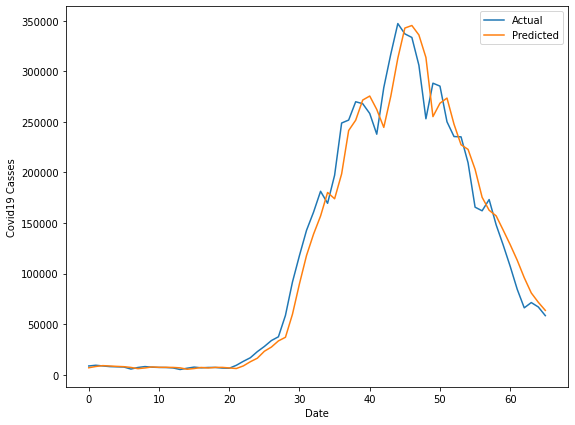

In [ ]:
# Plot
ax=df_actual.plot(label='Observed', figsize=(9,7))
df_pred.plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Covid19 Casses')
plt.legend()
plt.show()

## Step 6: Future Preiction

In order to predict the future value, we have to feed past data as the input. In the absence of past value we can use our predicted value of the corresponding day as the input. The Python code for all the above steps are given in the appendix for the future work.

In [ ]:
# Future Prediction

predictions=model.predict(X,verbose=1)
future_time_steps=15
x1=X[-1:,:,:]  # Take last input
x1=x1.astype('float64') 

p1=predictions[-1:]  # take last output

for i  in range(future_time_steps):
  x2=np.array([[x1[0][1],x1[0][2],x1[0][3],x1[0][4],x1[0][5], p1]], dtype=np.float)
  #print(x2)
  p2=model.predict(x2, verbose=1)
  predictions=np.append(predictions, p2)
  x1=x2
  p1=p2

yhat=predictions
yhat=np.reshape(yhat, (-1,1))

df_pred=pd.DataFrame.from_records(yhat, columns=['Predicted'])
df_pred=df_pred.reset_index(drop=True)

df_actual=df[n_steps:len(df)]
df_actual=df_actual.reset_index(drop=True)

In [ ]:
Predicted_data=pd.concat ([df_actual,df_pred],axis=1)
print(type(Predicted_data))
print(Predicted_data.shape)
print(Predicted_data)

<class 'pandas.core.frame.DataFrame'>
(81, 4)
         Date  Confirmed  Total Confirmed     Predicted
0  2021-12-07     8590.0       34657114.0   6831.448730
1  2021-12-08     9303.0       34666417.0   8098.260742
2  2021-12-09     8614.0       34675031.0   8936.638672
3  2021-12-10     7971.0       34683002.0   8560.402344
4  2021-12-11     7749.0       34690751.0   8191.314453
..        ...        ...              ...           ...
76        NaT        NaN              NaN  36679.203125
77        NaT        NaN              NaN  34909.742188
78        NaT        NaN              NaN  33225.796875
79        NaT        NaN              NaN  31623.041016
80        NaT        NaN              NaN  30097.552734

[81 rows x 4 columns]


## Step 7: Download the data

Write the Predicted data as .csv file and download it  for future purpose

In [ ]:
from google.colab import files
Predicted_data.to_csv('India -COVID-19 Prediction_simple LSTM.csv') 
files.download('India -COVID-19 Prediction_simple LSTM.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>